# Sentiment Analysis
Author: Junruo Zhu

Date: 4 Oct, 2023

This code performs sentiment analysis on the given corpus and returns the sentiment value (e.g. neu 0.8, pos 0.1, neg 0.1) for each text.

The input data is in csv format. Inout texts are readable, which means that texts are not lemmatized, and punctuation markers are not removed.

 * The code in the sentiment analysis scetion is adapted from code originally written by Rob Mulla. Original source: [ https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook#Step-3.-Roberta-Pretrained-Model ].
 * In acknowledgment of the contributions made, portions of this code were developed with the guidance and assistance of ChatGPT.






## Step 0. preprocessing and Quick View of data

In [ ]:
# installation
!pip install transformers

In [ ]:
# Get all libraries ready
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from scipy.special import softmax
from tqdm.notebook import tqdm

import torch
print(torch.cuda.is_available())

True


### Read preprocessed date sets

Academic

In [ ]:
# Read
# aca_df = pd.read_csv("/content/aca_sentiment_df.csv")
from google.colab import drive
drive.mount("/content/drive")
aca_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Masters_Thesis/0_corpus/preprocessed_for_sentiment_analysis/aca_sentiment_df.csv")

# Get an example text from this corpus
aca_example = aca_df["text"].iloc[0]
print(aca_example)
# Have a look at this dataset
aca_df.head()

Mounted at /content/drive
Changing the World One Meme at a Time: The Effects of Climate Change Memes on Civic Engagement Intentions. The risks that animals and humans face from climate change are frequently featured in climate change memes. Although memes may appear to some as silly jokes, little is known of the impact they may have in the formation and spread of individuals' perceived risk of climate change and intention to participate in climate change campaigns. This study tests the effect of climate change memes on the perceived risk of climate change and the intention of online engagement regarding climate change issues. Results show that exposure to climate change memes increases individual intentions of online civic engagement regarding climate change. Additionally, empathy is found to mediate this effect. However, risk perception of climate change is not altered after exposure to climate change memes.


,id,year,text
0,1,2021,Changing the World One Meme at a Time: The Eff...
1,2,2021,"The Relationship between Social Norms, Avoidan..."
2,3,2013,An Evaluation of Urban Citizens' Awareness of ...
3,4,2021,How and when higher climate change risk percep...
4,5,2022,Climate change impact and adaptation for highw...


Reddit

In [ ]:
# Read
red_df = pd.read_csv("/content/red_sentiment_df.csv")
# Get an example text from this corpus
red_example = red_df["text"].iloc[0]
print(red_example)
# Have a look at this dataset
red_df.head()

## Step 1. Prepare a Roberta Pretrained Model for Sentiment Analysis
I used "cardiffnlp/twitter-roberta-base-sentiment-latest" model from huggingface🤗.
Original Source: [https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest ]





### Adjust the model to be more suitable for long texts:

In [ ]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model = model.to("cuda")  # Move the model to GPU


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Define a function computing the sentiment scores of a long text
def analyze_sentiment(text: str):
    # Tokenize the input with overflow handling
    encodings = tokenizer(text, return_tensors="pt",
                          return_overflowing_tokens=True,
                          stride=256,
                          truncation=True,
                          padding="longest",
                          max_length=512).to("cuda")  # Move the encodings to GPU

    # Handle each segment and collect scores
    all_scores = []
    sentiment_dict = {}
    for i in range(len(encodings["input_ids"])):
        segment = {k: v[i].unsqueeze(0) for k, v in encodings.items()}
        # Remove the argument not needed by the model
        segment.pop("overflow_to_sample_mapping", None)

        output = model(**segment)
        scores = output[0][0].detach().cpu().numpy()
        scores = softmax(scores)
        all_scores.append(scores)


    # Calculate the mean of the scores for all segments ❗️
    mean_scores = np.mean(all_scores, axis=0)
    sentiment_dict = {
        "neg" : mean_scores[0],
        "neu" : mean_scores[1],
        "pos" : mean_scores[2]
    }

    return sentiment_dict

### To see how this model works on examples:

Example 1


In [ ]:
# a neutral sentence.
text = "Dogs ran away."
# Tokenize the input with overflow handling
encodings = tokenizer(text, return_tensors="pt", return_overflowing_tokens=True,
                      stride=256, truncation=True, padding="longest", max_length=512)
# See how many segments this model makes on the example
for i, input_ids in enumerate(encodings["input_ids"]):
    segment_text = tokenizer.decode(input_ids)
    print(f"Segment {i + 1}: \"{segment_text}\"")

# Get scores
analyze_sentiment(text)

Segment 1: "<s>Dogs ran away.</s>"


{'neg': 0.30162013, 'neu': 0.64975685, 'pos': 0.04862304}

Example 2

In [ ]:
# our example from the data set
text = aca_example
# Tokenize the input with overflow handling
encodings = tokenizer(text, return_tensors="pt", return_overflowing_tokens=True,
                      stride=256, truncation=True, padding="longest", max_length=512)
# See how many segments this model makes on the example
for i, input_ids in enumerate(encodings["input_ids"]):
    segment_text = tokenizer.decode(input_ids)
    print(f"Segment {i + 1}: \"{segment_text}\"")

# Get scores
analyze_sentiment(text)

Segment 1: "<s>Changing the World One Meme at a Time: The Effects of Climate Change Memes on Civic Engagement Intentions. The risks that animals and humans face from climate change are frequently featured in climate change memes. Although memes may appear to some as silly jokes, little is known of the impact they may have in the formation and spread of individuals' perceived risk of climate change and intention to participate in climate change campaigns. This study tests the effect of climate change memes on the perceived risk of climate change and the intention of online engagement regarding climate change issues. Results show that exposure to climate change memes increases individual intentions of online civic engagement regarding climate change. Additionally, empathy is found to mediate this effect. However, risk perception of climate change is not altered after exposure to climate change memes.</s>"


{'neg': 0.1873626, 'neu': 0.74770117, 'pos': 0.06493631}

## Step 2. Apply this model to the corpus

1.  I defined a main fucntion containing a series of functions first.
2.  I apply a main function to each corpus.


### Define subfunctions and a main function

In [ ]:
def apply_function_to_corpus(corpus):
    """
    Produce the sentiment scores of each text
    """
    results = {}
    for i, row in tqdm(corpus.iterrows(), total=len(corpus)):
        try:
            text = str(row["text"])
            myid = row["id"]

            result = analyze_sentiment(text)

            results[myid] = result
        except RuntimeError:
            print(f"Broke for id {myid}")
    return results


def save_results_to_a_dataframe(results, corpus):
    """
    Merge the results (sentiment scores) with corpus
    """
    # Make a new dataframe keeping the sentiment values
    results_df = pd.DataFrame(results).T
    results_df = results_df.reset_index().rename(columns={"index": "id"})
    # Create a new dataframe merging results_df with df
    results_df = results_df.merge(corpus, how="left")

    return results_df


def save_results_to_drive(results_df, save_path):
    """
    Save the DataFrame with sentiment scores for each text to a file.
    """
    results_df.to_csv(save_path, index=False)
    print(f"Dataframe saved to {save_path}")


def get_mean_of_sentiment(results_df):
    """
    Compute the average of each emotion across years
    """
    yearly_avg = results_df.groupby("year")[["neu",
                                             "pos",
                                             "neg"
                                             ]].mean().reset_index()

    return yearly_avg


def save_means_to_drive(yearly_avg, save_path):
    """
    Save the DataFrame with yearly average scores of sentiment to a file.
    """
    yearly_avg.to_csv(save_path, index=False)
    print(f"Dataframe saved to {save_path}")


def main(corpus, corpus_name):
    results = apply_function_to_corpus(corpus)
    merged_df = save_results_to_a_dataframe(results, corpus)
    yearly_avg = get_mean_of_sentiment(merged_df)

    # Save the merged DataFrame with sentiment values
    file_path = f"/content/{corpus_name}_sentiment_full.csv"
    save_results_to_drive(merged_df, file_path)

    # Save the yearly averages
    yearly_avg_path = f"/content/{corpus_name}_sentiment_yearly_avg.csv"
    save_results_to_drive(yearly_avg, yearly_avg_path)

    return merged_df, yearly_avg

### Apply to the academic corpus

In [ ]:
aca_merged_df, aca_yearly_avg = main(aca_df, "academic")

  0%|          | 0/14519 [00:00<?, ?it/s]

Dataframe saved to /content/academic_sentiment_full.csv
Dataframe saved to /content/academic_sentiment_yearly_avg.csv


In [ ]:
# check the result
print("Show the first 5 rows of the dataFrame with emotion values for each text.")
aca_merged_df.head()

Show the first 5 rows of the dataFrame with emotion values for each text.


,id,neg,neu,pos,year,text
0,1,0.187363,0.747701,0.064936,2021,Changing the World One Meme at a Time: The Eff...
1,2,0.027834,0.893852,0.078315,2021,"The Relationship between Social Norms, Avoidan..."
2,3,0.026384,0.840255,0.133362,2013,An Evaluation of Urban Citizens' Awareness of ...
3,4,0.292215,0.648509,0.059276,2021,How and when higher climate change risk percep...
4,5,0.238444,0.724061,0.037495,2022,Climate change impact and adaptation for highw...


In [ ]:
print("See the frist 10 rows of the means of each emotion values in every year.")
aca_yearly_avg.head(10)

See the frist 10 rows of the means of each emotion values in every year.


,year,neu,pos,neg
0,2013,0.781583,0.071845,0.146573
1,2014,0.770713,0.081209,0.148078
2,2015,0.781406,0.077299,0.141295
3,2016,0.769496,0.077330,0.153175
4,2017,0.767953,0.083151,0.148896
5,2018,0.776057,0.079111,0.144832
6,2019,0.764681,0.079800,0.155520
7,2020,0.757700,0.076749,0.165551
8,2021,0.755933,0.080672,0.163395
9,2022,0.750582,0.081560,0.167858


### Apply to the Reddit comment corpus


In [ ]:
red_merged_df, red_yearly_avg = main(red_df, "reddit")

  0%|          | 0/153857 [00:00<?, ?it/s]

Dataframe saved to /content/reddit_sentiment_full.csv
Dataframe saved to /content/reddit_sentiment_yearly_avg.csv


In [ ]:
# check the result
print("Show the first 5 rows of the dataFrame with emotion values for each text.")
red_merged_df.head()

Show the first 5 rows of the dataFrame with emotion values for each text.


,id,neg,neu,pos,year,text
0,c7w2a9f,0.658974,0.328784,0.012242,2013,Discussing climate change with a skeptic on an...
1,c7x3p76,0.685276,0.294212,0.020511,2013,That hasn't even been considered for several y...
2,c7xjxtf,0.457323,0.529474,0.013202,2013,anything on non- carbon dioxide GHGs? I though...
3,c7xkqi8,0.062936,0.749133,0.187931,2013,That would be easy to find as well since there...
4,c7xp7wy,0.010834,0.111506,0.877660,2013,"Cool, thanks"


In [ ]:
print("See the frist 10 rows of the means of each emotion values in every year.")
red_yearly_avg.head(10)

See the frist 10 rows of the means of each emotion values in every year.


,year,neu,pos,neg
0,2013,0.439474,0.157529,0.402996
1,2014,0.472462,0.165550,0.361988
2,2015,0.441063,0.103068,0.455870
3,2016,0.478973,0.148114,0.372912
4,2017,0.465163,0.135622,0.399215
5,2018,0.468377,0.142803,0.388820
6,2019,0.457736,0.145291,0.396973
7,2020,0.465571,0.138420,0.396009
8,2021,0.448101,0.148331,0.403568
9,2022,0.463200,0.146294,0.390506


## Step 3. Plot Results


In [ ]:
def plot(yearly_avg):
    # Colorblind-friendly colors
    colors = {
        "neg": "#e41a1c",  # red
        "neu": "#984ea3",  # purple
        "pos": "#ffff33",  # yellow
    }

    # Sentiment label mapping
    sentiment_labels = {
        "neg": "Negative Sentiment",
        "neu": "Neutral Sentiment",
        "pos": "Positive Sentiment"
    }

    # Plot content
    plt.figure(figsize=(12,7))

    sentiments = ["neg", "neu", "pos"]

    for sentiment in sentiments:
        # Filling between the line plot and x-axis
        plt.fill_between(yearly_avg["year"], yearly_avg[sentiment], alpha=0.2, label=sentiment_labels[sentiment], color=colors[sentiment])
        # Drawing the line plots
        plt.plot(yearly_avg["year"], yearly_avg[sentiment], color=colors[sentiment], marker="o")
        # Annotating the values on the plot
        for i, row in yearly_avg.iterrows():
            plt.annotate(f"{row[sentiment]:.2f}", (row["year"], row[sentiment]), ha="center", va="bottom", color=colors[sentiment])

    plt.title("Yearly Average Sentiment Values")
    plt.xlabel("Year")
    plt.ylabel("Average Sentiment Value")
    plt.legend()
    plt.grid(True)

    # Setting x-axis to show each year
    plt.xticks(yearly_avg["year"])

    plt.tight_layout()

    # Show the plot
    plt.show()

### Apply to the academic corpus

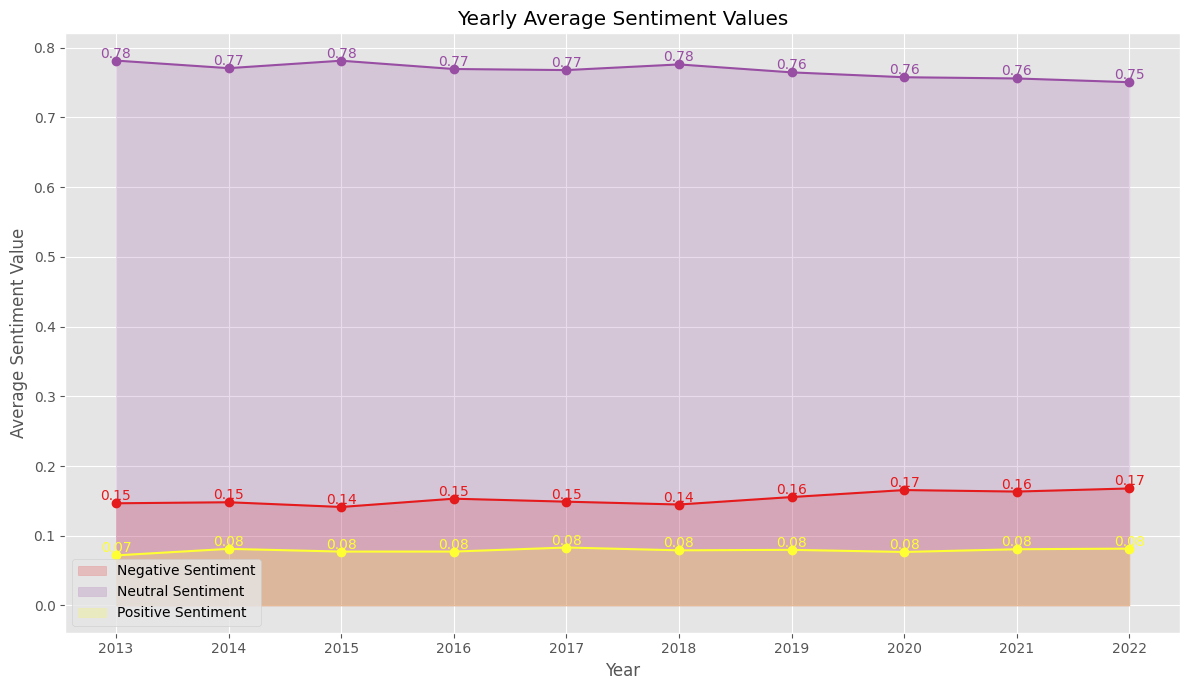

In [ ]:
plot(aca_yearly_avg)

### Apply to the Reddit corpus

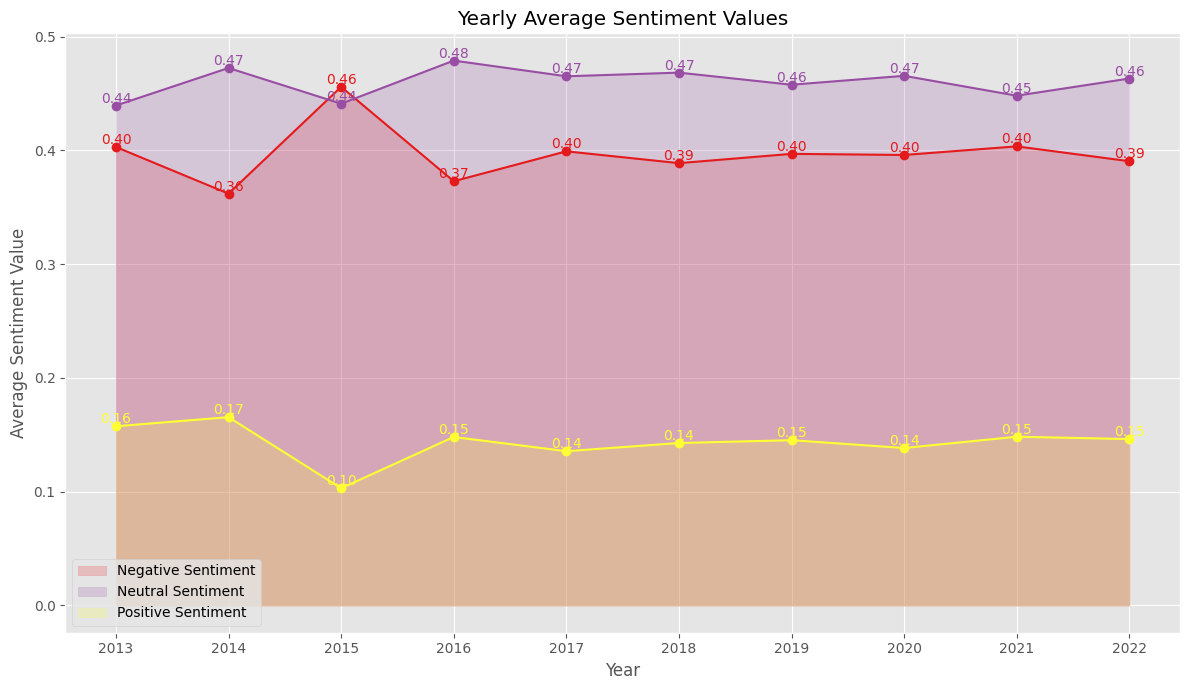

In [ ]:
plot(red_yearly_avg)